[1.58113883 1.58113883 1.58113883 1.58113883 1.58113883 1.58113883]
[1. 0. 0. 0.] [-1.00000000e+00  1.11022302e-16  0.00000000e+00  0.00000000e+00]
[[-1  1]]
[[ 1.        -0.5       -0.5      ]
 [ 0.        -0.8660254  0.8660254]]
[[ 1.         -0.33333333 -0.33333333 -0.33333333]
 [ 0.          0.94280904 -0.47140452 -0.47140452]
 [ 0.          0.         -0.81649658  0.81649658]]


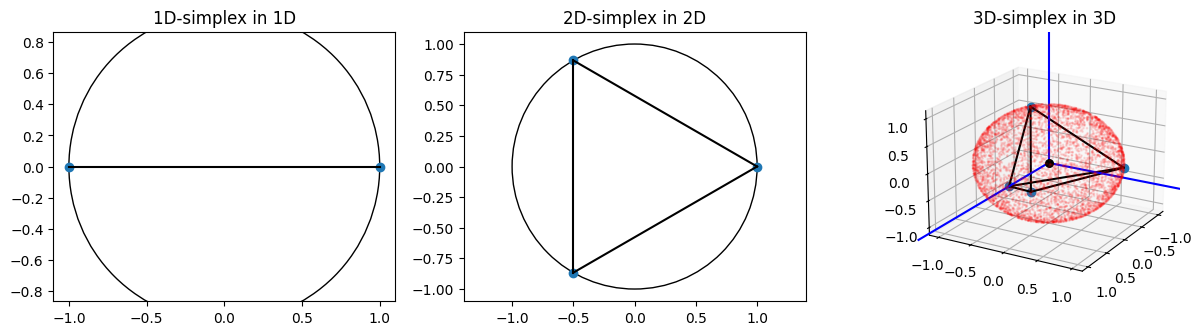

True

In [217]:

import abc
from typing import Any, cast
import numpy as np
import scipy.stats
import scipy.special
import matplotlib.pyplot as plt
import abc

# dist = UniformIsotropicDistribution(2, r=2)
# print(dist.norm_rms())
# dist = GaussianIsotropicDistribution(2, r=2)
# print(dist.norm_rms())


def dists_all_vs_all(V):
    d = V.shape[0]
    return np.array([np.linalg.norm(V[i]-V[j]) for i in range(d) for j in range(i+1, d)])

def plot_simplex_1_3():
    fig, axes = plt.subplots(1, 3, figsize=(15, 3.5))
    for ax, d in [(axes[0], 1), (axes[1], 2), (axes[2], 3)]:
        if d==3:
            # Delete this plot
            ax.remove()
            # Make a 3d plot centered at the origin
            ax = fig.add_subplot(133, projection='3d')
            ax.view_init(elev=20, azim=30) # type: ignore
        else:
            ax.add_artist(plt.Circle((0, 0), 1, fill=False))# type: ignore
        ax.axis('equal')
        ax.set_ylim(-1.1, 1.1)
        ax.set_xlim(-1.1, 1.1)
        if d==3:
            ax.set_zlim(-1.1, 1.1) # type: ignore
        ax.set_title(f"{d}D-simplex in {d}D")
        V = simplex_vertices_in_d_dimensions(d)
        print(V)
        if d==1:
            # Add zeroes to each column vector
            V = np.concatenate([V, np.zeros((1, d+1))])
        if d==1 or d==2:
            ax.plot(*V, 'o')
            for i,j in ((i,j) for i in range(d+1) for j in range(i+1, d+1)):
                ax.plot(*V[:,[i,j]], 'k-')
        else:
            # set 3d projection for axes[2]
            ax.plot(*V, 'o')
            for i,j in ((i,j) for i in range(d+1) for j in range(i+1, d+1)):
                ax.plot(*V[:,[i,j]], 'k-')
            # Plot a 3d sphere
            X = np.random.normal(size=(5000, 3))
            X /= np.linalg.norm(X, axis=1)[:, None]
            ax.scatter(X[:,0], X[:,1], X[:,2], s=1, c='r', alpha=0.1)# type: ignore
            ax.scatter(*np.zeros((3,1)), c='k', s=30)# type: ignore
            for v in 3*np.eye(3):
                ax.plot(*np.array([np.zeros(3), v]).T, 'b-')
    plt.show()

def simplex_vertices_in_d_dimensions(d:int):
    # The columns of V are the vertices of the d-dimensional simplex
    assert d > 0
    V = np.array([[-1, 1]])
    k = 2
    while k <= d:
        V_i = [([-1/k, *(np.sqrt(k**2-1)/k*u)]) for u in V.T]
        v_k = [1, *np.zeros(k-1)]
        V = np.array([v_k, *V_i]).T
        k += 1
    return V

f = lambda d: np.array([[-1], [1]] if d<=1 else [[1, *[0]*(d-1)], *[([-1/d, *((d**2-1)**.5/d*u)]) for u in f(d-1).T]]).T

V = simplex_vertices_in_d_dimensions(4)
print(dists_all_vs_all(V))
print(V[:,0], V[:,1:].sum(axis=1))
plot_simplex_1_3()

np.allclose(f(4), simplex_vertices_in_d_dimensions(4))


In [170]:

class SimplexOnSphere:

    def __init__(self, d:int):
        self.d = d
        self.side_length = np.sqrt(2*(d+1)/d)
        self.volume = np.sqrt((d+1)/2**d) / scipy.special.gamma(1+d) * self.side_length**d
        # The columns of V are the vertices of the simplex
        self.V = simplex_vertices_in_d_dimensions(d)
        self.affine_origin = np.ones((1, self.d+1)) / self.d

    def from_one_hot_space(self, X:np.ndarray):
        # X has rows of one-hot vectors
        return np.matmul(X, self.V.T)
    
    def to_one_hot_space(self, X:np.ndarray):
        # Project X on the column vectors of V
        Y = np.matmul(X, self.V)
        # Discard negative values, distributing them to the positive ones, and rescale
        Y = (Y + self.affine_origin) * (self.d / (self.d+1))
        # Fix numerical errors around 0 (very typical use case)
        Y[np.isclose(Y, 0, atol=1e-15)] = 0
        return Y

X4 = np.concatenate([np.eye(4), np.ones((1,4)) ,np.zeros((1,4)), [[0,0.5,0.5,0],[2,0,0,0]]])
s = SimplexOnSphere(3)
print(X4)
X3 = s.from_one_hot_space(X4)
# print(X3)
X4_again = s.to_one_hot_space(X3)
print(X4_again)

s.to_one_hot_space(s.from_one_hot_space(np.array([0,0,1,0])))

[[1.  0.  0.  0. ]
 [0.  1.  0.  0. ]
 [0.  0.  1.  0. ]
 [0.  0.  0.  1. ]
 [1.  1.  1.  1. ]
 [0.  0.  0.  0. ]
 [0.  0.5 0.5 0. ]
 [2.  0.  0.  0. ]]
[[ 1.    0.    0.    0.  ]
 [ 0.    1.    0.    0.  ]
 [ 0.    0.    1.    0.  ]
 [ 0.    0.    0.    1.  ]
 [ 0.25  0.25  0.25  0.25]
 [ 0.25  0.25  0.25  0.25]
 [ 0.    0.5   0.5   0.  ]
 [ 1.75 -0.25 -0.25 -0.25]]


array([[0., 0., 1., 0.]])

In [182]:

class SimplexIsometryOnSphere:

    def __init__(self, d:int):
        self.d = d
        self.side_length = np.sqrt(2*(d+1)/d)
        self.volume = np.sqrt((d+1)/2**d) / scipy.special.gamma(1+d) * self.side_length**d
        # The columns of V are the vertices of the simplex
        self.V = np.sqrt(self.d/(self.d+1))*simplex_vertices_in_d_dimensions(d)
        self.affine_origin = np.ones(self.d+1) / (self.d+1)

    def from_one_hot_space(self, X:np.ndarray):
        # X has rows of one-hot vectors
        return np.matmul(X, self.V.T)
    
    def to_one_hot_space(self, X:np.ndarray):
        Y = np.matmul(X, self.V)+ self.affine_origin
        Y[np.isclose(Y, 0, atol=1e-15)] = 0
        return Y

X4 = np.concatenate([np.eye(4), np.ones((1,4)) ,np.zeros((1,4)), [[0,0.5,0.5,0],[2,0,0,0]]])
s = SimplexIsometryOnSphere(3)
print(X4)
X3 = s.from_one_hot_space(X4)
print(np.linalg.norm(X3[1]-X3[0], axis=-1))
X4_again = s.to_one_hot_space(X3)
print(X4_again)

s.to_one_hot_space(s.from_one_hot_space(np.array([0,0,1,0])))

[[1.  0.  0.  0. ]
 [0.  1.  0.  0. ]
 [0.  0.  1.  0. ]
 [0.  0.  0.  1. ]
 [1.  1.  1.  1. ]
 [0.  0.  0.  0. ]
 [0.  0.5 0.5 0. ]
 [2.  0.  0.  0. ]]
1.4142135623730951
[[ 1.    0.    0.    0.  ]
 [ 0.    1.    0.    0.  ]
 [ 0.    0.    1.    0.  ]
 [ 0.    0.    0.    1.  ]
 [ 0.25  0.25  0.25  0.25]
 [ 0.25  0.25  0.25  0.25]
 [ 0.    0.5   0.5   0.  ]
 [ 1.75 -0.25 -0.25 -0.25]]


array([0., 0., 1., 0.])